In [44]:
import pandas as pd
from datetime import datetime
import numpy as np

In [ ]:
file = "./Midprices/min_data.csv"
try:
    df = pd.read_csv(file, index_col=0)
    df.index = pd.to_datetime(df.index)
    df = df.resample("1min").ffill()

except:
    df_AAPL = pd.read_csv("./Midprices/AAPL_1min_sample.csv", index_col=0)
    df_AAPL = df_AAPL["close"]
    df_AMZN = pd.read_csv("./Midprices/AMZN_1min_sample.csv", index_col=0)
    df_AMZN = df_AMZN["close"]
    df_GOOG = pd.read_csv("./Midprices/GOOG_1min_sample.csv", index_col=0)
    df_GOOG = df_GOOG["close"]
    df_META = pd.read_csv("./Midprices/META_1min_sample.csv", index_col=0)
    df_META = df_META["close"]
    df_NVDA = pd.read_csv("./Midprices/NVDA_1min_sample.csv", index_col=0)
    df_NVDA = df_NVDA["close"]
    df = pd.concat([df_AAPL, df_AMZN, df_GOOG, df_META, df_NVDA], axis=1, join='inner')
    df.columns = ["AAPL", "AMZN", "GOOG", "META", "NVDA"]
    df.to_csv(file)

In [70]:
df = df[df.index.date == min(df.index.date)]

In [71]:
# Estimate a VAR(1) model
from statsmodels.tsa.api import VAR
df_log = np.log(df)
model = VAR(df_log, freq='1min')
results = model.fit(1)

In [72]:
b = results.params.iloc[0,:].to_numpy()
C = results.params.iloc[1:,:].to_numpy()
omega = results.resid.cov().values

In [82]:
kappa = np.eye(5) - C
theta = np.linalg.inv(kappa) @ b
eig = np.linalg.eig(kappa)
U = eig.eigenvectors
D = eig.eigenvalues
D_tilde = D
D_tilde[1:] = 0
kappa_tilde = U @ np.diag(D_tilde) @ U.T
a = - kappa_tilde[0,:]
delta = - a / kappa_tilde[0,0]
nu = kappa_tilde @ theta + 1 / 2 * np.diag(omega) 

In [86]:
import numpy as np

def pi(tau: np.ndarray, alpha_t: np.ndarray, params):
    """
    Compute the optimal investment strategy π*.

    Parameters:
    Let n be the number of assets and T the number of time steps
    - tau (np.ndarray): Time-to-maturity vector (shape: (T,))
    - alpha_t (np.ndarray): Co-integration factor vector (shape: (T,))
    - params: Tuple containing (gamma, omega, delta, nu, a)
        - gamma (float): Risk aversion parameter
        - omega (ndarray): Covariance matrix (n, n)
        - delta (ndarray): Sensitivity vector (n, 1)
        - nu (ndarray): Drift vector (n, 1)
        - a (ndarray): Vector of weights (n, 1)

    Returns:
    - np.ndarray: Optimal investment matrix (T, n)
    """
    # Unpack parameters
    gamma, omega, delta, nu, a = params
    t = len(tau)

    A = np.diag(a)  # Diagonal matrix of a shape n x n
    omega_inv = np.linalg.inv(omega)

    # Compute common terms
    delta_T_omega = delta.T @ omega # Shape: (1, n)
    delta_T_omega_delta = delta_T_omega @ delta # Shape: (1, 1)
    delta_T_omega_nu = delta_T_omega @ nu # Shape: (1, 1)

    # Reshape tau and alpha_t to ensure correct broadcasting
    tau = tau[:, None]  # Shape (T, 1)
    alpha_t = alpha_t[:, None]  # Shape (T, 1)
    nu = nu[:, None]  # Shape (n,)
    delta = delta[:, None]  # Shape (n,)
    a = a[:, None]  # Shape (n,)

    # Compute first term: Omega inverse applied to (delta * alpha + nu)
    term1 = omega_inv @ (delta @ alpha_t.T + nu @ np.ones((1,t)))  # Shape: (n, T)

    # Compute second term: Adjustment based on short-term alpha and co-integration factor
    term2 = (1 / 2 * tau * (alpha_t - 2 * delta_T_omega_nu / delta_T_omega_delta))  # (T, 1)
    term3 = (1 / 4 * np.trace(A @ omega) * tau**2)  # (T, 1)

    # Final computation (broadcasted across tau and alpha_t)
    result = (1 / gamma) * (term1 +  a @ (delta_T_omega_delta * (term2 + term3).T))  # (n, T)

    return result.T  # (T, n)


In [88]:
def m(Y, tau : np.ndarray, alpha_t : np.ndarray, params):
    return pi(tau, alpha_t, params) / Y

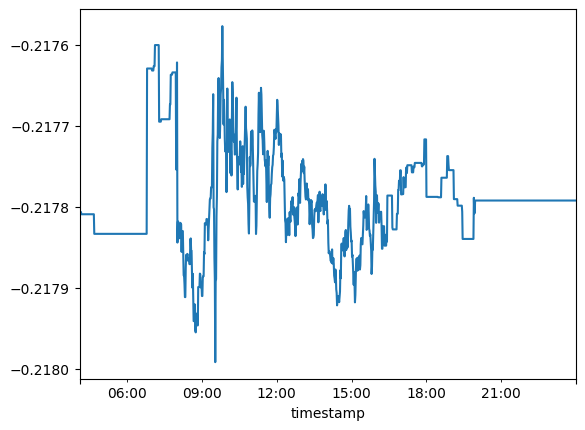

In [89]:
df_log["alpha"] = df_log.mul(a, axis=1).sum(axis=1)
df_log["alpha"].plot()
t = len(df_log)
df_log["tau"] = (t - np.arange(1, t + 1)) 
prices = df.values
params = 1, omega, delta, nu, a
portfolio = pd.Series((m(prices, df_log["tau"].values, df_log["alpha"].values, params) @ prices.T).sum(axis=1), index=df_log.index)

<Axes: xlabel='timestamp'>

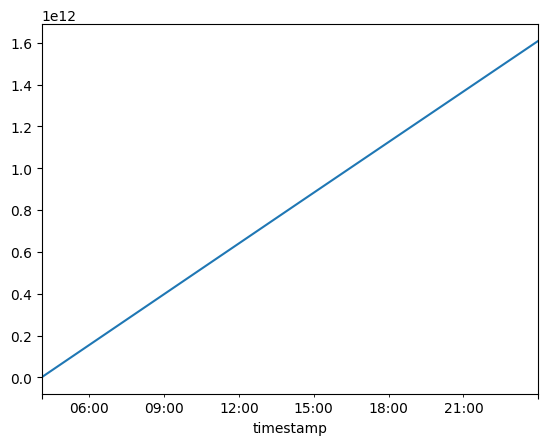

In [90]:
portfolio.cumsum().plot()